In [5]:
import mne 
from glob import glob 
import os
import matplotlib 
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import numpy as np
import pandas as pd

In [6]:
#matplotlib.use('Qt5Agg') 

In [7]:
#creo un array contenente i nomi dei file fif da leggere
nomi= [ 'D:\Epochs_pulite\epochs_1-epo.fif']
#, 'D:\Epochs_pulite\epochs_2-epo.fif', 'D:\Epochs_pulite\epochs_4-epo.fif', 'D:\Epochs_pulite\epochs_5-epo.fif',
#        'D:\Epochs_pulite\epochs_9-epo.fif', 'D:\Epochs_pulite\epochs_10-epo.fif','D:\Epochs_pulite\epochs_11-epo.fif',
#        'D:\Epochs_pulite\epochs_13-epo.fif','D:\Epochs_pulite\epochs_14-epo.fif','D:\Epochs_pulite\epochs_16-epo.fif', 'D:\Epochs_pulite\epochs_19-epo.fif', 'epochs_21-epo.fif',
#        'D:\Epochs_pulite\epochs_24-epo.fif','D:\Epochs_pulite\epochs_26-epo.fif','D:\Epochs_pulite\epochs_27-epo.fif', 'D:\Epochs_pulite\epochs_29-epo.fif', 
#        'D:\Epochs_pulite\epochs_30-epo.fif','D:\Epochs_pulite\epochs_33-epo.fif','D:\Epochs_pulite\epochs_34-epo.fif',
#        'D:\Epochs_pulite\epochs_35-epo.fif','D:\Epochs_pulite\epochs_36-epo.fif','D:\Epochs_pulite\epochs_37-epo.fif', 'D:\Epochs_pulite\epochs_38-epo.fif', 'epochs_39-epo.fif', 'epochs_40-epo.fif', 
#        'D:\Epochs_pulite\epochs_42-epo.fif','D:\Epochs_pulite\epochs_45-epo.fif','D:\Epochs_pulite\epochs_46-epo.fif',
#        'D:\Epochs_pulite\epochs_47-epo.fif']
print(len(nomi))

#leggo le epochs dai file fif
epochs_vector=[]
epochs_vector=[mne.read_epochs(i, proj=False, preload=True, verbose=None)for i in nomi]
print(len(epochs_vector))

#applico baseline alle epochs
for i in range (len(nomi)):
    epochs_vector[i].apply_baseline((None, 0))

1
Reading D:\Epochs_pulite\epochs_1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
22073 matching events found
No baseline correction applied
1
Applying baseline correction (mode: mean)


In [12]:
epochs=epochs_vector[0]

In [155]:
print(len(epochs['10001'])) #tutti  
print(len(epochs['10002'])) #animali 
print(len(epochs['10003'])) #uomini
print(len(epochs['10004'])) #cibo 
print(len(epochs['10005'])) #
print(len(epochs['10006'])) #strumenti 


15167
1299
2646
453
1592
916


In [198]:
#10002 e 10004 --> 0.74% acc 
epochs_a=epochs['10002'].get_data(picks=[15,17,16,45,46,48,47])
epochs_u=epochs['10004'].get_data(picks=[15,17,16,45,46,48,47])


print(epochs_a.shape)
print(epochs_u.shape)

(1299, 7, 276)
(453, 7, 276)


In [199]:
EV_a=np.mean(epochs_a, axis=1)
EV_u=np.mean(epochs_u, axis=1)

##############################
print(EV_a.shape)
print(EV_u.shape)



(1299, 276)
(453, 276)


In [200]:
#crop
EV_a= [np.delete(EV_a[i,:],np.arange(186,276,1)) for i in range(len(EV_a))]
EV_u= [np.delete(EV_u[i,:],np.arange(186,276,1)) for i in range(len(EV_u))]

EV_a[0].shape

(186,)

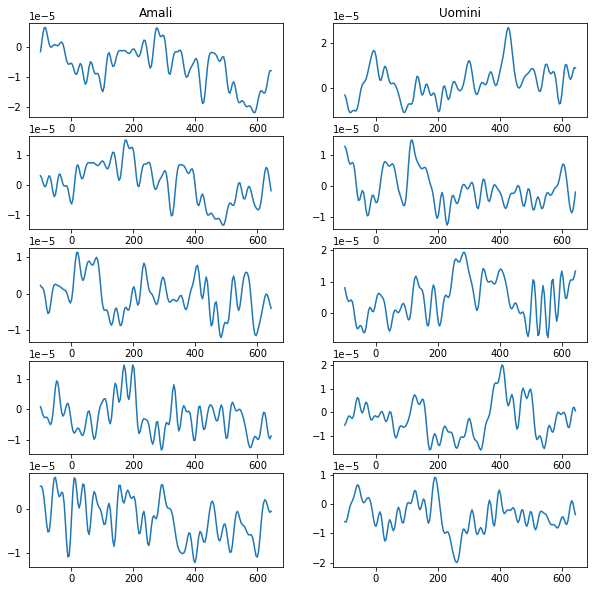

In [201]:
x=np.linspace(-100,644,186)
figure, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

axes[0, 0].set_title('Amali')
axes[0, 1].set_title('Uomini')
for  i in range(5):
    axes[i, 0].plot(x,EV_a[i])
    axes[i, 1].plot(x,EV_u[i]) 

In [202]:
#PROVO AD APPLICARE LA SCATTERING WAVELET 
from kymatio.numpy import Scattering1D
#Scattering Wavelet 
T =len(EV_a[0])
J = 4
Q = 10
print(T,J,Q)
scattering = Scattering1D(J, T, Q)

meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

186 4 10


In [203]:
vett_Sc_animali=[scattering(EV_a[i])for i in range(len(EV_a))]
vett_Sc_uomini =[scattering(EV_u[i])for i in range(len(EV_u))]

In [204]:
Features_a=[np.concatenate( (np.mean(i[order1],axis=1) , np.mean(i[order2],axis=1)))for  i in vett_Sc_animali]
Features_u=[np.concatenate( (np.mean(i[order1],axis=1) , np.mean(i[order2],axis=1)))for  i in vett_Sc_uomini]

In [205]:
df1 = pd.DataFrame (Features_a)
df2 = pd.DataFrame (Features_u)
frames = [df1, df2]
features = pd.concat(frames)

In [206]:
#LABELS 
a_type=np.zeros(len(EV_a), dtype=int)
b_type=np.ones(len(EV_u), dtype=int)
labels=np.concatenate((a_type,b_type))

In [207]:
from sklearn.preprocessing import StandardScaler
df=StandardScaler().fit_transform(features) 

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc 1','pc 2'])

In [208]:
#CON PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
clf = svm.SVC(kernel='poly',degree=2, C=1)
splitter=KFold(n_splits=10, shuffle=True)
scores = cross_val_score(clf, principalDf, labels, cv=splitter)
print("ACCURATEZZA TEN - FOLD - 2 PCA" )
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(),scores.std()))

#SENZA PCA 
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
clf = svm.SVC(kernel='poly',degree=2, C=1)
splitter=KFold(n_splits=10, shuffle=True)
scores = cross_val_score(clf, features, labels, cv=splitter)
print("ACCURATEZZA TEN - FOLD")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(),scores.std()))

0.74 accuracy with a standard deviation of 0.03


In [209]:
#SENZA PCA 
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
clf = svm.SVC(kernel='poly',degree=2, C=1)
splitter=KFold(n_splits=10, shuffle=True)
scores = cross_val_score(clf, features, labels, cv=splitter)
print("ACCURATEZZA TEN - FOLD")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(),scores.std()))

0.74 accuracy with a standard deviation of 0.04


In [ ]:


sklearn.metrics.precision_recall_fscore_support(y_true, y_pred)